> ### EEE3314: Introduction to Artificial Intelligence

# Assignment \# III: Ridge & LASSO Regression

### *Assignement Instructions:*
- **Due date**: 11 PM, Oct. 8 (Fri), 2021
- **File name**: [ID_Name_HW3.ipynb]
- Write a program implementing a particular algorithm to solve a given problem.   
- **Report and discuss your results. Analyze the algorithm, theoretically and empirically.**

### *Collaboration policy:*
- You may discuss the questions with your friends, but each student writes their own codes and answers.  
- **Cheating is strictly prohibited, and will be considered academic dishonesty. This is not how you want to start your career as an engineer.** We expect that most students can distinguish between helping other students and cheating. Explaining the meaning of a question or discussing a way of approaching a solution is an interaction. But you should write your homework solution strictly by yourself so that your hands and eyes can help you internalize the subject matter. You should acknowledge everyone whom you have worked with, or who has given you any significant ideas about the homework
- Signiture: <span style="color:blue">[Insert your ID HERE] [Insert your name HERE]</span>

In [1]:
import datetime
# print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-09-28 02:41:05.029785


In [2]:
%load_ext autoreload
%autoreload 2

## Problem statement

The training set ($\texttt{crime-train.csv}$) consists of statistics of local crime for 1,595 communities. Our goal is to estimate the crime rate ($\texttt{ViolentCrimesPerPop}$) using 95 features, including the size of the police force or the percentage of children that graduate high school. Detailed descriptions of the features are avaialbe at the following website: http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names.

Let's estimate regression models using training samples to predict the crime rate, and evaluate them on the test set ($\texttt{crime-test.csv}$). To this end, suppose that the number of featrues and other statistics for the test set are exactly the same as those for the training set. 


**Note #1**:
You can use ```linalg.inv```, ```transpose```, ```dot```, ```sum```, ```concatenate```, ```min``` and ```max``` provided by ```Numpy```. Other mehtods (e.g., ```sklearn.linear_model``` or equivalent) should not be used. You will get no credit otherwise. 

**Note #2**: For handling the intercept term, refer the lecture note 5, page 46-53.  


**Note #3**: We will use **unnormalized features**. Please refer the lecture note 6, page 40-42.

### P1. Linear regression 

P1.1 Implement a linear regression method (```LinearRegressor``` class) using **a coordinate descent algorithm**, and estimate regression coefficients for features including a bias (intercept) term. (*20 points*) 

> **Convergence condition**: Stop the iteration if $||\hat w_t - \hat w_{t+1}||_\infty < \tau$, where $\hat w_t$  is estimated coefficients at time $t$. $t$ is a number of iteration, and $\tau (=10^{-3})$ is a tolerance. Note that the infinity norm of a vector ${\bf{x}}=(x_1,x_2,\dots,x_n)$ is defined as $||{\bf{x}}||_\infty = max(|x_1|,|x_2|,\dots,|x_n|)$.
>
> **Loss function**: RSS
>
> **Initialization**: Set all weight values (including the bias term) to random Gaussian with mean of 0 and standard deviation of 1 $\left( \mathcal{N}(0, 1) \right)$.
>
> Pick the next coordinate squentially (i.e., $0, 1, 2, \dots$).

P1.2 Plot prediction errors on training samples, over the number of iterations. Use the RSS as an error metric. (*5 points*) 

Since there are a considerable number of input variables, overfitting might occur, which prevents trained models from generalizing unseen test samples. 
Regularization techniques such as ridge and LASSO have proven useful for the overfitting problem.

### P2. Ridge regression 

P2.1  Implement a ridge regression method (```RidgeRegressor``` class which **inherits** from the ```LinearRegressor``` class in **P1**) using **a coordinate descent algorithm**, and estimate regression coefficients for features including a bias (intercept) term. Suppose that other conditions are the same as **P1**. (*20 points*)

P2.2 Plot prediction errors on training samples, over the number of iterations, for the model with the regularization parameter $\lambda$ being 5. Use the RSS as an error metric. (*5 points*)


### P3. Lasso regression 

P3.1 Implement a ridge regression method (```LassoRegressor``` class which **inherits** from the ```LinearRegressor``` class in **P1**) using **a coordinate descent algorithm**, and estimate regression coefficients for features including a bias (intercept) term. Suppose that other conditions are the same as **P1**. (*20 points*)


P3.2 Plot prediction errors on training samples, over the number of iterations, for the model with the regularization parameter $\lambda$ being 5. Use the RSS as an error metric. (*5 points*)

### P4. Analysis

P4.1 Run the code provided to plot magnitudes of estimated coefficients for each method. Analyze and contrast regression methods (linear regression without regularization, ridge regression, and lasso regression) in terms of the magnitudes of coefficients. *(5 points)*  

P4.2 Implement the ```stack_weight_over_lambda``` function that outputs a stack of regression coefficients for regularization parameters. Run the code provided to plot coefficient paths of given features over the regularization parameter. The parameter starts and ends from the values of 0 and 100, respectively, with the increment of 5. Analyze coefficient paths for ridge and lasso regression methods. *(5 points)* 

P4.3 Implement the ```get_number_of_non_zero``` function that counts the number of non-zero values for regression coefficients. Run the code provided, and analyze ridge and lasso regression methods in terms of the number of non-zero coefficients. *(5 points)*  

P4.4 Implement the ```compute_errors``` function that inputs a set of regression coefficients for different regularization parameters (obtained by the ```stack_weight_over_lambda``` function) and output the error (**RSS**) between predictions and target values. *(5 points)* 

P4.5 Run the code provided to plot training and test errors using the ```compute_errors``` function. Analyze results for linear regression without regularization, ridge regression, and lasso regression in terms of the prediction error. *(5 points)*  

## Results

In [3]:
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from project3 import *


class Dataset:
    """
    Dataset class
    """
    
    def __init__(self, data_path):
        """
        Description:
            Load a csv file using 'load_data' method.
            Convert the dataframe to numpy array.
        
        Args:
            data_path (str): Path of the csv file.
                       
        Returns:
            
        """
        assert type(data_path)==str, 'The type of data_path has to be string'
        
        self.path = data_path
        self.features, self.data = self.load_data()
        self.min = None
        self.max = None        
                
    def load_data(self):
        """
        Description:
            Load the csv file.
            Print the head of data. 
        
        Args: 
            
            
        Returns:
            features (list): The names of the features.
            data (numpy array): Data.
        """
        dataframe = pd.read_csv(self.path)
        print(dataframe.head())
        features = list(dataframe)[:-1]
        data = dataframe.values
        return features, data

    def parse_data(self, features):
        """
        Description:
            Parse the data using 'features'.
            Add a bias to the data.
        
        Args:
            features (list): The names of feature we use.
        
        Returns:
            X (numpy array): Input data.
            y (numpy arary): Target (feature name: 'ViolentCrimesPerPop').
            
        """
        assert type(features)==list, 'The type of feature_names has to be list'
        assert all([isinstance(feature, str) for feature in features]), 'The element of features has to be string'
            
        data = deepcopy(self.data)
        indices = [self.features.index(feature) for feature in features]
        X = data[:, indices]
        y = data[:, -1]
        
        bias = np.ones([len(self.data), 1])
        X = np.concatenate((bias, X), axis=1)
        
        return X, y


### Instantiate the ```Dataset``` class

In [4]:
data_path = 'crime-train.csv'
dataset = Dataset(data_path)

   population  householdsize  agePct12t21  agePct12t29  agePct16t24  \
0       -0.45          -1.85        -1.06         0.67         0.08   
1       -0.45          -0.27        -0.22        -0.17        -0.34   
2       -0.14           1.87         0.55         0.04         0.02   
3       -0.38           0.53        -0.28        -0.79        -0.64   
4       -0.30          -1.12        -0.74        -0.10        -0.40   

   agePct65up  numbUrban  pctUrban  medIncome  pctWWage  ...  PctForeignBorn  \
0       -0.85      -0.34      0.68      -0.24      0.88  ...           -0.02   
1       -0.58      -0.50     -1.57      -0.29      0.12  ...           -0.33   
2       -1.19      -0.03      0.68       1.05      1.81  ...           -0.11   
3       -0.35      -0.34      0.46       0.66      0.88  ...           -0.46   
4       -0.30      -0.19      0.68       0.76      0.67  ...            2.10   

   PctBornSameState  PctSameHouse85  PctSameCity85  PctSameState85  LandArea  \
0           

### Prepare training samples

In [5]:
X, y = dataset.parse_data(features=dataset.features)
print(f"shape of X: {X.shape}, shape of y: {y.shape}")

shape of X: (1595, 96), shape of y: (1595,)


In [6]:
X[3,:]

array([ 1.  , -0.38,  0.53, -0.28, -0.79, -0.64, -0.35, -0.34,  0.46,
        0.66,  0.88, -0.64,  1.04, -0.18, -0.94,  1.38,  0.43,  0.42,
        0.22, -0.06, -1.24,  2.14,  0.51, -0.43, -1.06, -0.31, -0.41,
       -0.15, -1.2 ,  0.86,  1.35, -0.35,  0.14,  0.1 , -1.32, -0.94,
       -1.64, -1.55,  0.14,  1.48,  1.4 ,  1.03,  1.39, -0.6 ,  0.42,
       -0.33, -0.83, -0.34, -1.32, -1.38, -0.99, -0.81, -0.73, -0.69,
       -0.61, -0.57,  0.41, -0.46, -0.55, -0.32,  0.75,  0.67, -0.18,
        1.66, -0.79, -1.77,  0.73, -0.44,  0.88,  1.73, -0.76,  0.62,
        1.01, -0.88, -0.5 ,  0.2 ,  0.2 ,  0.13,  0.24, -0.06, -0.17,
       -0.02, -1.59,  0.32, -1.01, -0.29, -0.23, -0.46,  0.54,  0.58,
       -0.08, -0.61, -0.23, -0.7 , -0.62, -0.39])

---

### Instantiate a linear regression model

In [7]:
least_square = LinearRegressor(tau=1e-3, dim=X.shape[1])

### P1.1

In [8]:
least_square.LR_with_coordinate_descent(X, y)
print(least_square.weight)

[ 2.36221267e-01 -5.17522720e-03 -3.32981324e-04  2.66364094e-03
 -3.45830069e-02 -2.92826667e-02  9.56380484e-03 -2.91579276e-02
  2.20093607e-02 -1.85724179e-02 -4.54093253e-02  6.54841849e-03
 -4.13424358e-02  9.89835948e-04 -2.01382613e-03 -1.01494644e-02
  4.79172588e-02 -6.50598259e-02  5.46998569e-03 -3.39353953e-04
 -3.34744493e-03  5.03107211e-03  1.11789688e-02  3.37485111e-02
 -4.43514597e-02 -1.73681207e-02  3.54922314e-03  1.52878258e-02
  3.46888256e-03  4.79676629e-02 -1.39664297e-02  3.04342798e-03
  2.18581688e-02  1.07198631e-02 -2.62948307e-01  6.35811959e-02
 -4.02559150e-01  6.43683238e-01 -8.50286258e-03  6.31368251e-02
 -1.35304050e-01 -8.73644044e-03 -2.88348986e-03  7.25237875e-03
 -3.17200062e-02 -2.19468767e-02  5.12898600e-02 -1.57250609e-02
  3.04425058e-03 -5.50977884e-03  6.57447742e-03 -7.14387436e-04
 -2.46734765e-02  4.90553114e-02 -7.27408132e-02  6.21589392e-02
 -2.18384767e-02 -5.78226798e-02 -1.26562277e-02 -9.03668253e-03
  1.99790675e-01 -1.30416

### P1.2

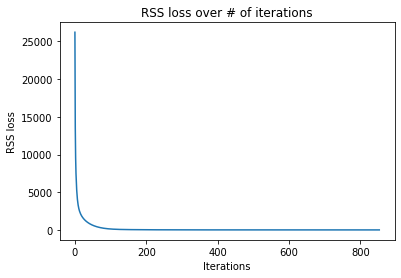

In [9]:
least_square.plot_loss_history()

---

### Instantiate a ridge regression model

In [10]:
ridge = RidgeRegressor(tau=1e-3, dim=X.shape[1], lambda_=5)

### P2.1

In [11]:
ridge.LR_with_coordinate_descent(X, y)
print(ridge.weight)

[ 2.36327367e-01 -1.25009305e-02  5.00685117e-03  1.48114248e-02
 -1.98083676e-02 -3.73257386e-02  1.93580647e-02 -1.22852733e-02
  1.93778053e-02  6.28037085e-02 -2.17743035e-02  5.81783728e-03
 -3.62105799e-02  1.09541754e-02 -4.51046117e-03 -1.07227670e-02
  5.22561577e-03 -7.64280995e-02  1.04946864e-02 -1.32955762e-03
 -3.61665213e-03  5.11052516e-03  1.18764400e-02  2.62433481e-02
 -2.60456348e-02 -1.41973826e-02  7.84755776e-03  9.36956966e-03
  4.99977451e-03  4.00082581e-02 -1.29651171e-02  4.42560269e-03
  1.76252038e-02  1.35535025e-02 -2.26225702e-02  3.96621912e-02
 -9.42124966e-02  1.10650978e-01 -8.85656714e-03 -5.77720470e-03
 -7.29958801e-02 -2.97494949e-03 -2.58579945e-03  8.73577396e-03
 -3.11867671e-02 -2.27367152e-02  5.49897197e-02 -1.55639334e-02
 -6.68501646e-03  2.24271249e-04  9.01489520e-03  2.04237239e-03
  3.04416284e-02 -1.11045500e-02 -7.27002296e-02  4.46287209e-02
 -7.53966226e-03 -5.12688690e-02  5.82784172e-03 -2.46295626e-02
  8.43933986e-02 -4.91533

### P2.2

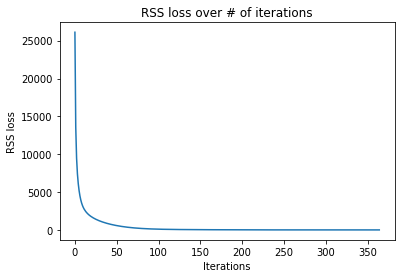

In [12]:
ridge.plot_loss_history()

---

### Instantiate a lasso regression model

In [13]:
lasso = LassoRegressor(tau=1e-3, dim=X.shape[1], lambda_=5)

### P3.1

In [14]:
lasso.LR_with_coordinate_descent(X, y)
print(lasso.weight)

[ 2.35794443e-01  0.00000000e+00  2.21686968e-03  0.00000000e+00
 -1.68896593e-02  0.00000000e+00  5.94800190e-03  0.00000000e+00
  1.56753747e-02  0.00000000e+00  0.00000000e+00  1.12616195e-04
 -1.98575074e-02  0.00000000e+00  0.00000000e+00 -7.29834873e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.14054198e-03  2.70038982e-03  8.12865704e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.95848456e-04  0.00000000e+00 -4.28732872e-03  3.19215613e-04
  0.00000000e+00  1.29574902e-03  8.91377751e-03  8.56128932e-04
  0.00000000e+00  0.00000000e+00  2.28165260e-03  0.00000000e+00
 -7.56173987e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.72022798e-03  0.00000000e+00  6.86196575e-02 -9.66723350e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.70248106e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.78167973e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

### P3.2

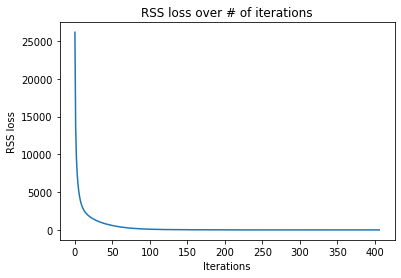

In [15]:
lasso.plot_loss_history()

---

### P4.1

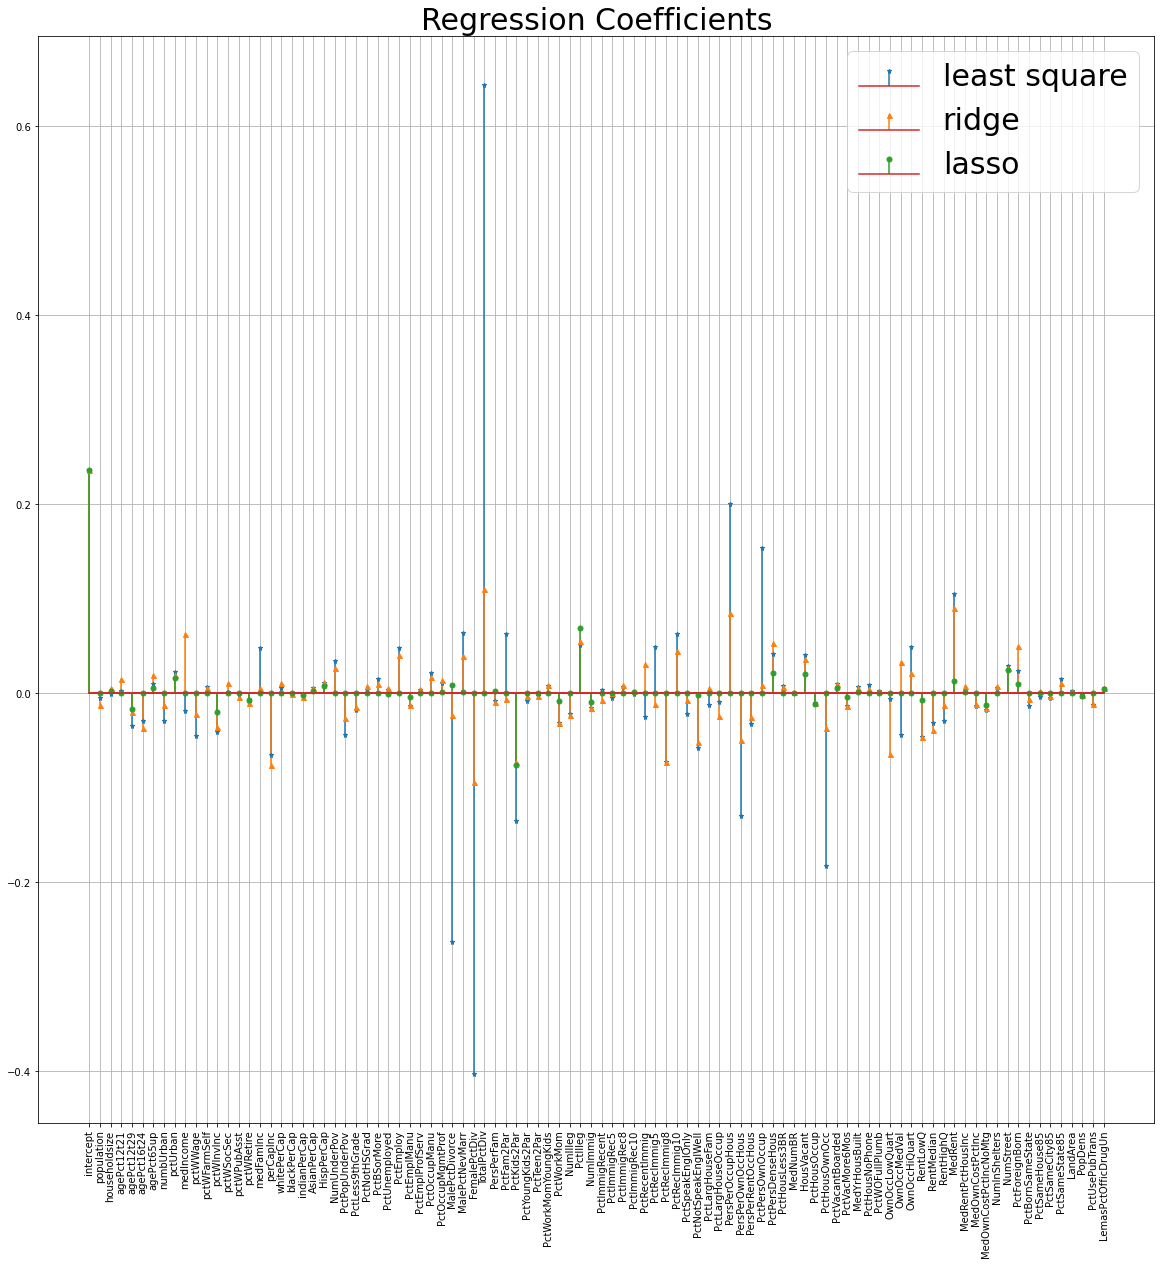

In [16]:
plt.figure(figsize=[20, 20])

markerline, stemlines, baseline = plt.stem(range(0, 96), least_square.weight, label='least square')
plt.setp(markerline, markersize=5, color='#1f77b4', marker='*')
plt.setp(stemlines, color=plt.getp(markerline, 'color'))
plt.setp(stemlines, linestyle='-')

markerline, stemlines, baseline = plt.stem(range(0, 96), ridge.weight, label='ridge')
plt.setp(markerline, markersize=5, color='#ff7f0e', marker='^')
plt.setp(stemlines, color=plt.getp(markerline,'color'))
plt.setp(stemlines, linestyle='-')

markerline, stemlines, baseline = plt.stem(range(0, 96), lasso.weight, label='lasso')
plt.setp(markerline, markersize=5, color='#2ca02c', marker='o')
plt.setp(stemlines, color=plt.getp(markerline,'color'))
plt.setp(stemlines, linestyle='-')

plt.xticks(range(0, 96), ['intercept']+dataset.features, rotation=90)
plt.title('Regression Coefficients', fontsize=30)

plt.grid()
plt.legend(fontsize=30)
plt.show()

Describe your analysis here

---

### P4.2

In [17]:
def plot_regularization_paths(weights, lambda_list, model_type, features):
    assert model_type in ['Lasso', 'Ridge'], f"model_type must be 'Ridge' or 'Lasso' but were given {model_type}"
    indices = [dataset.features.index(feature) for feature in features]
    plt.figure(figsize=[30, 10])
    plt.plot(lambda_list, weights[:, indices], markersize=20, marker=(5,1))
    plt.title(f"Regularization paths of {model_type} regression", fontsize=30)
    plt.xlabel('$\lambda$', fontsize=30)
    plt.ylabel('weights', fontsize=30)
    plt.legend(features, fontsize=20, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

In [18]:
lambda_list = np.array(range(0, 101, 5))
print(lambda_list)

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


In [19]:
stacked_weight_ridge = stack_weight_over_lambda(X, y, 'Ridge', 1e-3, X.shape[1], lambda_list)

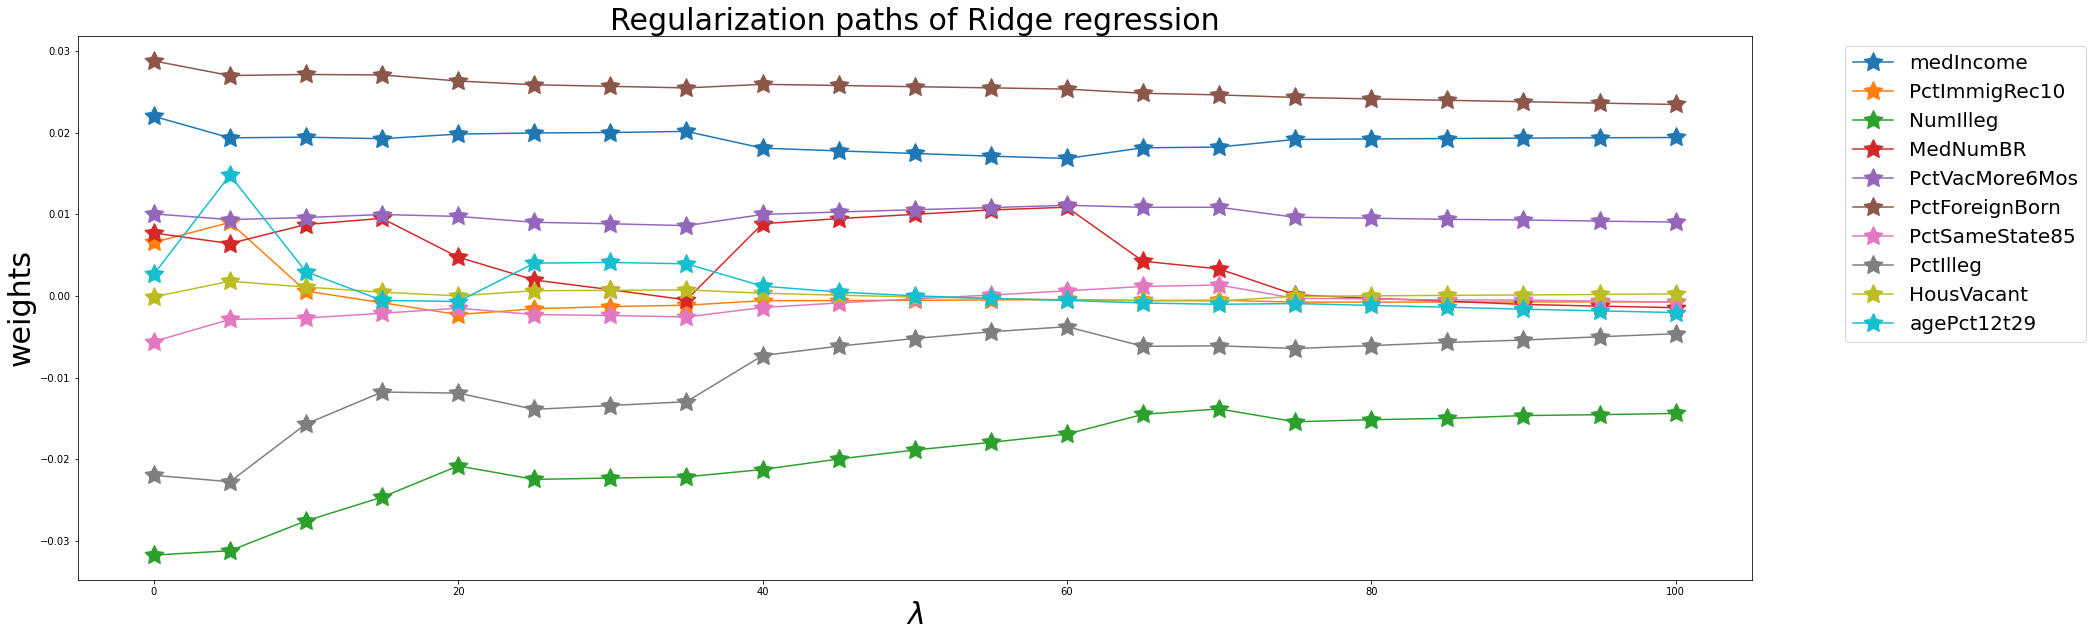

In [20]:
features = [
    'medIncome',
    'PctImmigRec10',
    'NumIlleg',
    'MedNumBR',
    'PctVacMore6Mos',
    'PctForeignBorn',
    'PctSameState85',
    'PctIlleg',
    'HousVacant',
    'agePct12t29'
]

plot_regularization_paths(stacked_weight_ridge, lambda_list, 'Ridge', features)

In [21]:
stacked_weight_lasso = stack_weight_over_lambda(X, y, 'Lasso', 1e-3, X.shape[1], lambda_list)

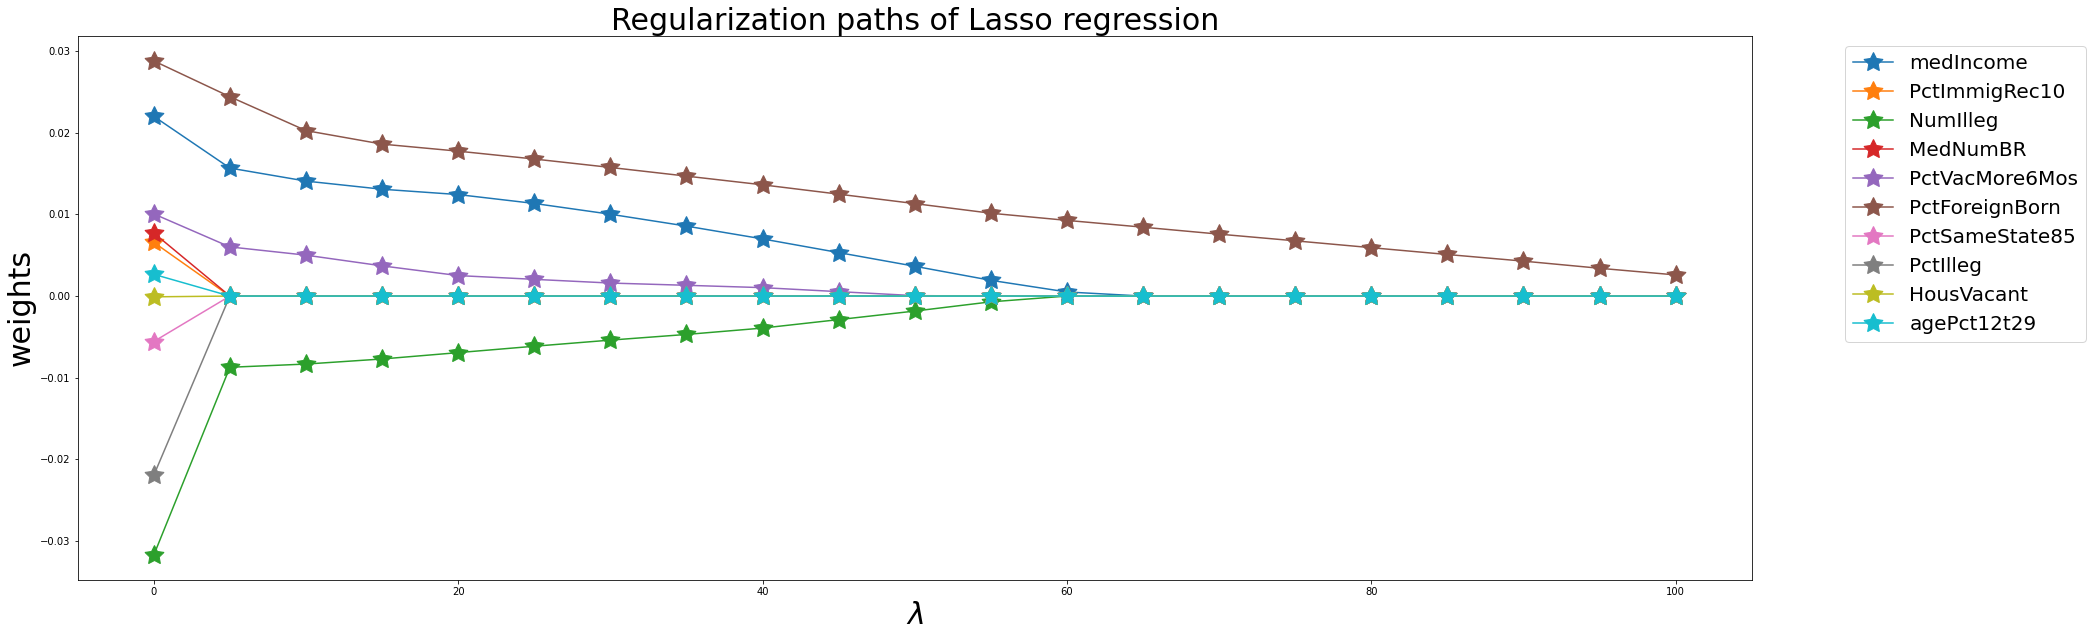

In [22]:
plot_regularization_paths(stacked_weight_lasso, lambda_list, 'Lasso', features)

describe your analysis here

---

### P4.3

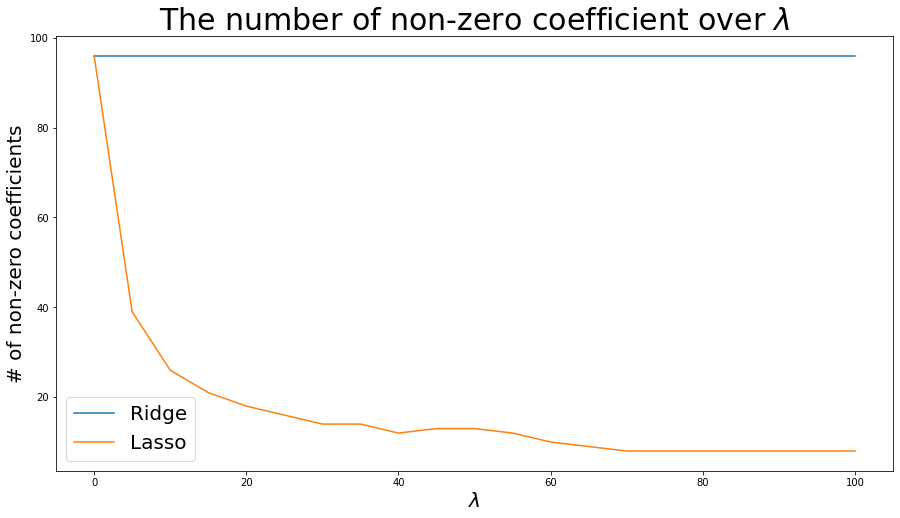

In [23]:
plt.figure(figsize=[15, 8])
plt.plot(lambda_list, get_number_of_non_zero(stacked_weight_ridge), label='Ridge')
plt.plot(lambda_list, get_number_of_non_zero(stacked_weight_lasso), label='Lasso')
plt.title(f"The number of non-zero coefficient over $\lambda$", fontsize=30)
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('# of non-zero coefficients', fontsize=20, rotation=90)
plt.legend(fontsize=20)
plt.show()

Describe your analysis here.

---

### P4.5

In [24]:
training_errors_ridge = compute_errors(X, y, lambda_list, stacked_weight_ridge)
training_errors_lasso = compute_errors(X, y, lambda_list, stacked_weight_lasso)

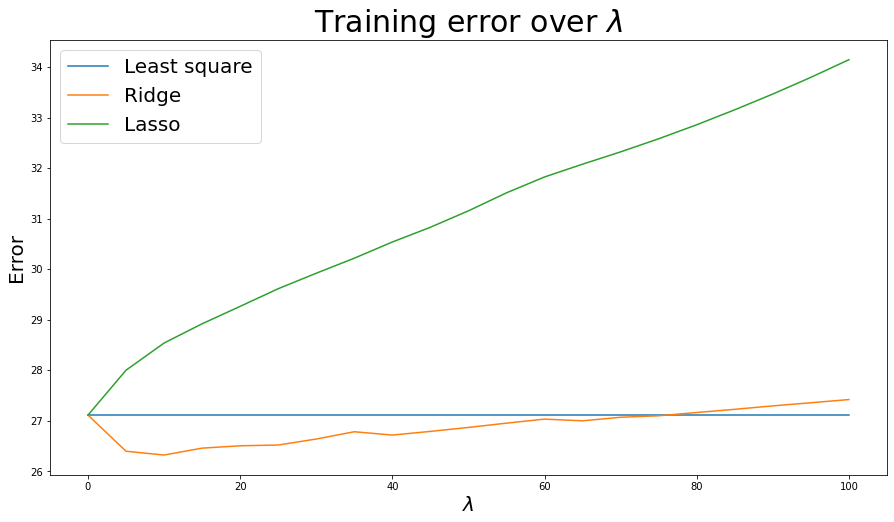

In [25]:
plt.figure(figsize=[15, 8])
plt.plot(lambda_list, [least_square.loss[-1]]*len(lambda_list), label='Least square')
plt.plot(lambda_list, training_errors_ridge, label='Ridge')
plt.plot(lambda_list, training_errors_lasso, label='Lasso')
plt.title(f"Training error over $\lambda$", fontsize=30)
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('Error', fontsize=20, rotation=90)
plt.legend(fontsize=20)
plt.show()

Describe your analyis here

---

In [26]:
test_data_path = 'crime-test.csv'
test_dataset = Dataset(test_data_path)

   population  householdsize  agePct12t21  agePct12t29  agePct16t24  \
0       -0.14           0.35        -0.41        -0.10        -0.46   
1        0.02          -0.45        -0.22        -0.24        -0.40   
2       -0.45           0.28        -0.16         0.18        -0.46   
3        0.02          -0.27        -0.67        -0.51        -0.58   
4       -0.22           1.20         3.71         3.53         3.99   

   agePct65up  numbUrban  pctUrban  medIncome  pctWWage  ...  PctForeignBorn  \
0       -1.41      -0.11      0.48       1.43      1.70  ...           -0.24   
1       -0.19       0.12      0.68      -0.29      0.06  ...           -0.80   
2       -1.25      -0.34      0.68       0.14      1.54  ...           -0.67   
3       -0.69       0.12      0.68       0.95      0.67  ...            0.54   
4       -1.19      -0.11      0.68      -1.25      0.45  ...            0.54   

   PctBornSameState  PctSameHouse85  PctSameCity85  PctSameState85  LandArea  \
0           

In [27]:
X_test, y_test = test_dataset.parse_data(features=test_dataset.features)
print(f"shape of X: {X_test.shape}, shape of y: {y_test.shape}")

shape of X: (399, 96), shape of y: (399,)


In [28]:
test_error_least_square = np.sum((y_test - X_test.dot(least_square.weight)) ** 2)
test_errors_ridge = compute_errors(X_test, y_test, lambda_list, stacked_weight_ridge)
test_errors_lasso = compute_errors(X_test, y_test, lambda_list, stacked_weight_lasso)

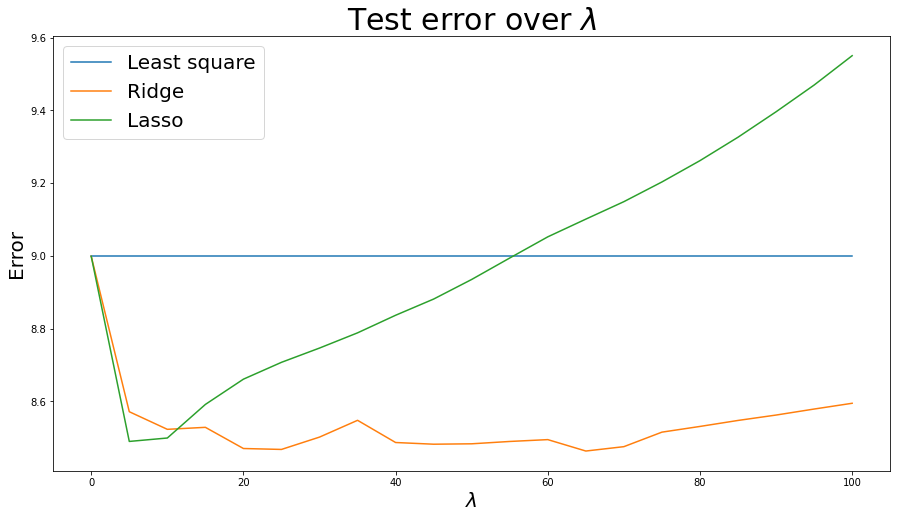

In [29]:
plt.figure(figsize=[15, 8])
plt.plot(lambda_list, [test_error_least_square]*len(lambda_list), label='Least square')
plt.plot(lambda_list, test_errors_ridge, label='Ridge')
plt.plot(lambda_list, test_errors_lasso, label='Lasso')
plt.title(f"Test error over $\lambda$", fontsize=30)
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('Error', fontsize=20, rotation=90)
plt.legend(fontsize=20)
plt.show()

Describe your analysis here.

---